# Weekly Project 5
## Global Registration implementation.
## Task 1
Today your project is to implement a global registration algorithm.

It should be able to roughly align two pointclouds.
1. Implement global registration
2. Can you fit **r1.pcd** and **r2.pcd**?
3. Can you fit **car1.ply** and **car2.ply**?
These are in the *global_registration* folder



## Task 2 (Challange)
Challanges attempt either or both:
- Implement local registration.

- Attempt to reconstruct the car from the images in *car_challange* folder.

You can use the exercises from monday as a starting point.

## Task 1

In [1]:
### Task-1
# 1:

import open3d as o3d
import numpy as np
import copy

def draw_registrations(source, target, transformation = None, recolor = False):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    if(recolor):
        source_temp.paint_uniform_color([1, 0.706, 0])
        target_temp.paint_uniform_color([0, 0.651, 0.929])
    if(transformation is not None):
        source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-03-03 08:52:19,615 - utils - NumExpr defaulting to 8 threads.


In [2]:
source = o3d.io.read_point_cloud("global_registration/r1.pcd")
target = o3d.io.read_point_cloud("global_registration/r2.pcd")

# Used for downsampling.
voxel_size = 0.05

In [6]:

source_sample = source.voxel_down_sample(voxel_size)
target_sample = target.voxel_down_sample(voxel_size)

default_tree = o3d.geometry.KDTreeSearchParamHybrid(radius=10,max_nn=60)

source_sample.estimate_normals()
target_sample.estimate_normals()

source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(source_sample, default_tree)
target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(target_sample, default_tree)

print(len(source_sample.points))
print(len(target_sample.points))

4760
3440


In [7]:
####
# Call RANSAC here
####
distance_threshold = 10
point_to_point =  o3d.pipelines.registration.TransformationEstimationPointToPoint(with_scaling=False)
ransac_result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    source_sample, target_sample,
    source_fpfh, target_fpfh, 1, 
    distance_threshold,
    point_to_point)
draw_registrations(source, target, ransac_result.transformation, True)

KeyboardInterrupt: 

In [30]:
print(ransac_result.transformation)

[[ 0.00458377  0.00587761  0.99997222  2.01745733]
 [ 0.99972478  0.02298049 -0.00471771  1.97167438]
 [-0.02300758  0.99971864 -0.00577066  0.02405391]
 [ 0.          0.          0.          1.        ]]


In [27]:
from scipy.spatial import KDTree
target_tree = KDTree(np.transpose(target_fpfh.data))
corres_stock = target_tree.query(np.transpose(source_fpfh.data))

In [32]:
print(len(corres_stock[0]))

3490


In [37]:
import cv2
import open3d as o3d
from matplotlib import pyplot as pyplot
import numpy as np
import copy
import scipy
from scipy import spatial 
import random
import sys
import math

#Kabsch Algorithm
def compute_transformation(source,target):
    #Normalization
    number = len(source)
    #the centroid of source points
    cs = np.zeros((3,1))
    #the centroid of target points
    ct = copy.deepcopy(cs)
    cs[0] = np.mean(source[:][0]);cs[1]=np.mean(source[:][1]);cs[2]=np.mean(source[:][2])
    ct[0] = np.mean(target[:][0]);cs[1]=np.mean(target[:][1]);cs[2]=np.mean(target[:][2])
    #covariance matrix
    cov = np.zeros((3,3))
    #translate the centroids of both models to the origin of the coordinate system (0,0,0)
    #subtract from each point coordinates the coordinates of its corresponding centroid
    for i in range(number):
        sources = source[i].reshape(-1,1)-cs
        targets = target[i].reshape(-1,1)-ct
        cov = cov + np.dot(sources,np.transpose(targets))
    #SVD (singular values decomposition)
    u,w,v = np.linalg.svd(cov)
    #rotation matrix
    R = np.dot(u,np.transpose(v))
    #Transformation vector
    T = ct - np.dot(R,cs)
    return R, T

#compute the transformed points from source to target based on the R/T found in Kabsch Algorithm
def _transform(source,R,T):
    points = []
    for point in source:
        points.append(np.dot(R,point.reshape(-1,1)+T))
    return points

#compute the root mean square error between source and target
def compute_rmse(source,target,R,T):
    rmse = 0
    number = len(target)
    points = _transform(source,R,T)
    for i in range(number):
        error = target[i].reshape(-1,1)-points[i]
        rmse = rmse + math.sqrt(error[0]**2+error[1]**2+error[2]**2)
    return rmse

def draw_registrations(source, target, transformation = None, recolor = False):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    if(recolor): # recolor the points
        source_temp.paint_uniform_color([1, 0.706, 0])
        target_temp.paint_uniform_color([0, 0.651, 0.929])
    if(transformation is not None): # transforma source to targets
        source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

def pc2array(pointcloud):
    return np.asarray(pointcloud.points)

def registration_RANSAC(source,target,source_feature,target_feature,ransac_n=3,max_iteration=100000,max_validation=100):
    #the intention of RANSAC is to get the optimal transformation between the source and target point cloud
    s = pc2array(source) #(4760,3)
    t = pc2array(target)
    #source features (33,4760)
    sf = np.transpose(source_feature.data)
    tf = np.transpose(target_feature.data)
    #create a KD tree
    tree = spatial.KDTree(tf)
    corres_stock = tree.query(sf)[1]
    for i in range(max_iteration):
        #take ransac_n points randomly
        idx = [random.randint(0,s.shape[0]-1) for j in range(ransac_n)]
        corres_idx = corres_stock[idx]
        source_point = s[idx,...]
        target_point = t[corres_idx,...]
        #estimate transformation
        #use Kabsch Algorithm
        R, T = compute_transformation(source_point,target_point)
        #calculate rmse for all points
        source_point = s
        target_point = t[corres_stock,...]
        rmse = compute_rmse(source_point,target_point,R,T)
        #compare rmse and optimal rmse and then store the smaller one as optimal values
        if not i:
            opt_rmse = rmse
            opt_R = R
            opt_T = T
        else:
            if rmse < opt_rmse:
                opt_rmse = rmse
                opt_R = R
                opt_T = T
    return opt_R, opt_T

#used for downsampling
voxel_size = 0.05
#this is to get the fpfh features, just call the library
def get_fpfh(cp):
    cp = cp.voxel_down_sample(voxel_size)
    cp.estimate_normals()
    return cp, o3d.pipelines.registration.compute_fpfh_feature(cp, o3d.geometry.KDTreeSearchParamHybrid(radius=5, max_nn=100))


source = o3d.io.read_point_cloud('global_registration/r1.pcd')
target = o3d.io.read_point_cloud('global_registration/r2.pcd')   
#if we want to use RANSAC registration, get_fpfh features should be acquired firstly                 
r1, f1 = get_fpfh(source)
print('DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD')
r2, f2 = get_fpfh(target)
print('CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC')
R, T = registration_RANSAC(r1,r2,f1,f2)
print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
#transformation matrix is formed by R, T based on np.hstack and np.vstack(corporate two matrices by rows)
#Notice we need add the last row [0 0 0 1] to make it homogeneous 
transformation = np.vstack((np.hstack((np.float64(R), np.float64(T))), np.array([0,0,0,1])))
print('BBBBBBBBBBBBBBBBBBBBBBBBBBB')
draw_registrations(r1, r2, transformation, True)

DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
BBBBBBBBBBBBBBBBBBBBBBBBBBB
[Open3D WARNING] GLFW Error: X11: Failed to open display 192.168.8.228:0.0
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [40]:

draw_registrations(r1, r2, transformation, True)

KeyboardInterrupt: 

In [ ]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

pcd_down, pcd_fpfh = preprocess_point_cloud()

In [9]:
source = o3d.io.read_point_cloud("global_registration/car1.ply")
target = o3d.io.read_point_cloud("global_registration/car2.ply")

# Used for downsampling.
voxel_size = 0.05


source_sample = source.voxel_down_sample(voxel_size)
target_sample = target.voxel_down_sample(voxel_size)

default_tree = o3d.geometry.KDTreeSearchParamHybrid(radius=10,max_nn=60)

source_sample.estimate_normals()
target_sample.estimate_normals()

source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(source_sample, default_tree)
target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(target_sample, default_tree)

print(len(source_sample.points))
print(len(target_sample.points))

3490
3606


In [13]:
####
# Call RANSAC here
####
distance_threshold = 0.2
point_to_point =  o3d.pipelines.registration.TransformationEstimationPointToPoint(with_scaling=False)
ransac_result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    source_sample, target_sample,
    source_fpfh, target_fpfh, 1, 
    distance_threshold,
    point_to_point)
draw_registrations(source, target, ransac_result.transformation, True)

## Task 2

In [14]:
# Read in images. We have images 000000 - 0000400
color_raw0 = o3d.io.read_image("./car_challange/rgb/0000001.jpg")
depth_raw0 = o3d.io.read_image("./car_challange/depth/0000001.png")

color_raw1 = o3d.io.read_image("./car_challange/rgb/0000005.jpg")
depth_raw1 = o3d.io.read_image("./car_challange/depth/0000005.png")

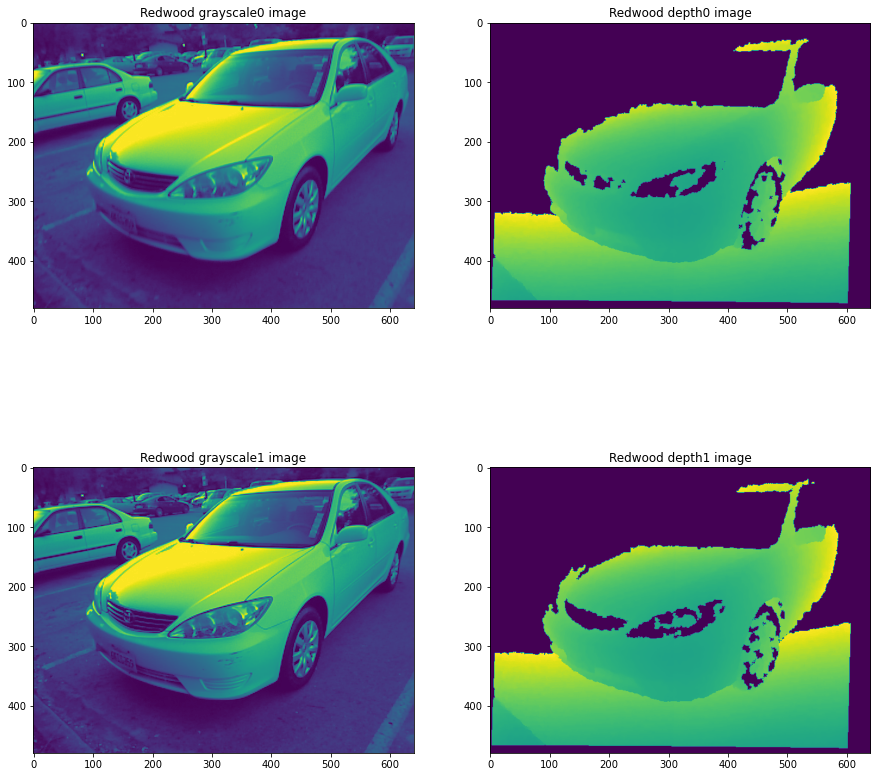

In [15]:
import matplotlib.pyplot as plt

rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw1, 
    depth_raw1, 
    convert_rgb_to_intensity = True)

#show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color)

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth)

plt.subplot(223)
plt.title('Redwood grayscale1 image')
plt.imshow(rgbd_image1.color)

plt.subplot(224)
plt.title('Redwood depth1 image')
plt.imshow(rgbd_image1.depth)

plt.show()

In [16]:
# Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Draw
draw_registrations(source, target, recolor=True)

In [17]:
# Parameters
threshold = 0.02
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=4.492835e-01, inlier_rmse=1.156006e-02, and correspondence_set size of 74679
Access transformation to get result.


In [18]:
source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30),fast_normal_computation=True)
target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30),fast_normal_computation=True)

point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.pipelines.registration.registration_icp(source, target, threshold, trans_init,point_to_plane)

draw_registrations(source, target, recolor=True)